In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime



In [2]:
conn = sqlite3.connect('papcorns.sqlite')

In [3]:
#Import Users Table into dataframe

users_df = pd.read_sql_query("SELECT*FROM users;",conn)

In [4]:
#Import Users Event Table into dataframe

events_df = pd.read_sql_query("SELECT*FROM user_events;",conn)

In [5]:
#Check columns and records's amount of Users df

users_df.shape

(1002, 5)

In [6]:
#Check columns and records's amount of Users Event df

events_df.shape

(3486, 5)

In [7]:
#lets remove id in events_df. user_id is reference od id in users_df


events_df = events_df.drop(columns='id',axis = 1)

In [8]:
#There is a problem with created column cronologically. There are some date at the future so those values should be removed from dataset

events_df['created_at'] = pd.to_datetime(events_df['created_at'])


In [9]:
row1 = events_df.shape[0]

In [10]:
events_df.drop(events_df[events_df['created_at']>pd.Timestamp.now()].index,axis = 0,inplace=True)

In [11]:
row2 = events_df.shape[0]

In [12]:
print(row1-row2,' rows are dropped from events_df')

173  rows are dropped from events_df


In [13]:
#Modify subscription_renewed depending on counts of done based on user_id
#There are multiple time for renewd that s aproblem convert our dataframe into pivot table
#Thats why we redesign oour subscription_renewed rows based on user_id

events_df['event_name'] = events_df['event_name'].astype('category')


renewed_counts = events_df[events_df['event_name'] == 'subscription_renewed'].groupby('user_id').size().reset_index(name='subscription_renewed')


In [14]:
#Create new dataframe with count of subscription_renewed  

x_df = events_df[['user_id']].drop_duplicates()  
df_subscription_renewed = x_df.merge(renewed_counts, on='user_id', how='left')

In [15]:
df_subscription_renewed

,user_id,subscription_renewed
0,1,NaN
1,2,3.0
2,3,3.0
3,4,NaN
4,5,NaN
...,...,...
997,998,NaN
998,999,1.0
999,1000,NaN
1000,1001,NaN


In [16]:
filtered_df = events_df[events_df['event_name']!='subscription_renewed']

In [17]:
#removed rows including 'subscription_renewed'


filtered_df['event_name'].value_counts()

app_install               1002
trial_started              682
subscription_started       479
subscription_cancelled     305
trial_cancelled            200
subscription_renewed         0
Name: event_name, dtype: int64

In [18]:
#Convert dataframe pivot table indexed by user_id, 
#create columns with event name without subscription renewed

df_pivot_no_renewed = filtered_df.pivot_table(index='user_id', columns='event_name', values='created_at')

In [19]:
df_pivot_no_renewed = df_pivot_no_renewed.reset_index()

In [20]:
#Dataframe without subscription_renewed

df_pivot_no_renewed

event_name,user_id,app_install,subscription_cancelled,subscription_started,trial_cancelled,trial_started
0,1,2024-05-07,NaT,NaT,2024-05-24,2024-05-12
1,2,2024-10-12,2025-02-12,2024-10-20,NaT,2024-10-13
2,3,2024-10-15,2025-01-20,2024-10-21,NaT,2024-10-19
3,4,2024-08-28,NaT,NaT,2024-09-06,2024-08-31
4,5,2024-04-03,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...
997,998,2025-02-01,NaT,NaT,NaT,NaT
998,999,2024-12-24,NaT,2025-01-03,NaT,2024-12-29
999,1000,2025-02-13,NaT,NaT,2025-02-25,2025-02-15
1000,1001,2025-02-25,NaT,2025-02-25,NaT,2025-02-25


In [21]:
#Finally merge pivot table with  subscription_renewed counts 

df_final = df_pivot_no_renewed.merge(df_subscription_renewed, on='user_id', how='inner')

In [22]:
df_final

,user_id,app_install,subscription_cancelled,subscription_started,trial_cancelled,trial_started,subscription_renewed
0,1,2024-05-07,NaT,NaT,2024-05-24,2024-05-12,NaN
1,2,2024-10-12,2025-02-12,2024-10-20,NaT,2024-10-13,3.0
2,3,2024-10-15,2025-01-20,2024-10-21,NaT,2024-10-19,3.0
3,4,2024-08-28,NaT,NaT,2024-09-06,2024-08-31,NaN
4,5,2024-04-03,NaT,NaT,NaT,NaT,NaN
...,...,...,...,...,...,...,...
997,998,2025-02-01,NaT,NaT,NaT,NaT,NaN
998,999,2024-12-24,NaT,2025-01-03,NaT,2024-12-29,1.0
999,1000,2025-02-13,NaT,NaT,2025-02-25,2025-02-15,NaN
1000,1001,2025-02-25,NaT,2025-02-25,NaT,2025-02-25,NaN


In [23]:
#Widen dataframe with column users table by merging based on user_id
#.drop(columns = ['key_0']) disallow create duplicated columns during merging

df_final =  pd.merge(df_final,users_df[['attribution_source','country','name']]\
                     , left_on=df_final['user_id'],right_on =users_df['id'], how='inner').drop(columns = ['key_0'])

In [24]:
df_final.head()

,user_id,app_install,subscription_cancelled,subscription_started,trial_cancelled,trial_started,subscription_renewed,attribution_source,country,name
0,1,2024-05-07,NaT,NaT,2024-05-24,2024-05-12,NaN,instagram,US,Eve Brown
1,2,2024-10-12,2025-02-12,2024-10-20,NaT,2024-10-13,3.0,instagram,NL,Frank Moore
2,3,2024-10-15,2025-01-20,2024-10-21,NaT,2024-10-19,3.0,tiktok,TR,Ivy Anderson
3,4,2024-08-28,NaT,NaT,2024-09-06,2024-08-31,NaN,tiktok,TR,Alice Brown
4,5,2024-04-03,NaT,NaT,NaT,NaT,NaN,organic,NL,Bob Moore


## APP_INSTALL DURATION

In [25]:
(df_final['trial_started']-df_final['app_install'])\
    .dt.days.value_counts(dropna =False)\
    .sort_index()

0.0      1
1.0    113
2.0    121
3.0    113
4.0    118
5.0    105
6.0    111
NaN    320
dtype: int64

In [26]:
#The rate start trial to app_install

print('%',round((df_final['trial_started']-df_final['app_install'])\
    .dt.days.value_counts(dropna =True)\
    .sort_index().sum()/ (df_final['trial_started']-df_final['app_install'])\
    .dt.days.value_counts(dropna =False)\
    .sort_index().sum()*100,2))

% 68.06


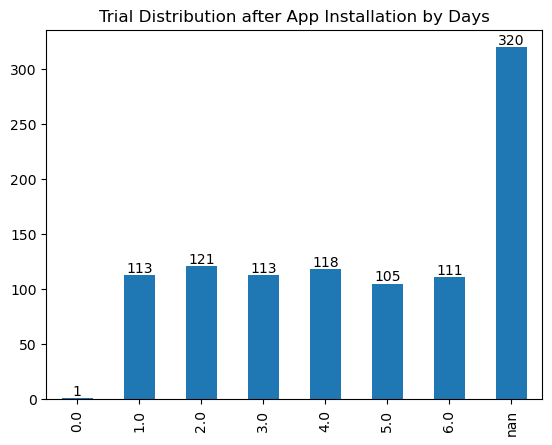

In [27]:
#Distribution of app_install-TO-trial
#Trials have been started in former 6 days then never

ax = (df_final['trial_started']-df_final['app_install'])\
    .dt.days.value_counts(dropna =False)\
    .sort_index().plot(kind='bar')

ax.bar_label(ax.containers[0])
plt.title('Trial Distribution after App Installation by Days')
plt.show()

In [28]:
#Add a new colum of app_install duration
#It seems it is disallowed to use trial after 6 days
#Even though so. I use this method to overcome Null value problem
#If I do no subtract app_install date from now then whole value return Nan
#By this way i can use app_install duration for non-trial as well in my data set
#and normalization and standardization also overcome for huges value of duration of app_install

df_final['Duration_app_install'] = [(df_final.loc[i,'trial_started']-df_final.loc[i,'app_install']).days\
                                             if pd.notna(df_final.loc[i,'trial_started'])\
                                             else (pd.Timestamp.now()-df_final.loc[i,'app_install']).days
                                             for i in df_final.index ]

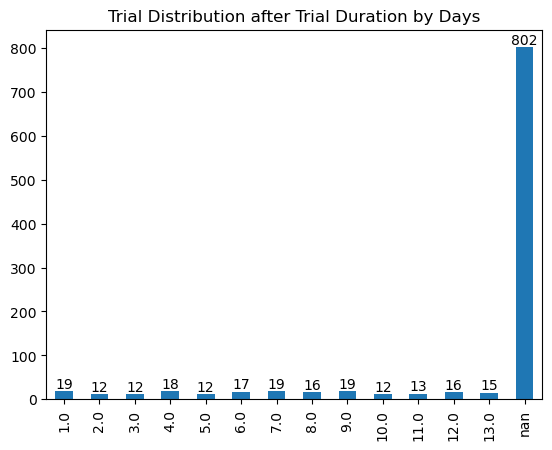

In [29]:
#Distribution of Trial Duration
#Trial Duration have been taken in former 2 weeks atmost

ax = (df_final['trial_cancelled']-df_final['trial_started'])\
.dt.days.value_counts(dropna =False).sort_index().plot(kind='bar')

ax.bar_label(ax.containers[0])
plt.title('Trial Distribution after Trial Duration by Days')
plt.show()

## Trial DURATION

In [30]:
[(df_final.loc[i,'trial_cancelled']-df_final.loc[i,'trial_started']).days\
                                             if pd.notna(df_final.loc[i,'trial_cancelled'])\
                                             else (df_final.loc[i,'subscription_started']-df_final.loc[i,'trial_started']).days
                                             for i in df_final.index ]

[12,
 7,
 2,
 6,
 nan,
 9,
 nan,
 13,
 11,
 12,
 9,
 6,
 4,
 12,
 12,
 4,
 11,
 nan,
 nan,
 nan,
 nan,
 3,
 nan,
 13,
 11,
 nan,
 13,
 6,
 nan,
 12,
 9,
 1,
 nan,
 2,
 9,
 12,
 3,
 1,
 4,
 7,
 4,
 nan,
 nan,
 nan,
 nan,
 8,
 nan,
 9,
 nan,
 4,
 nan,
 8,
 nan,
 5,
 5,
 nan,
 2,
 11,
 10,
 8,
 3,
 nan,
 3,
 6,
 nan,
 nan,
 nan,
 11,
 nan,
 nan,
 nan,
 6,
 11,
 13,
 5,
 8,
 7,
 nan,
 nan,
 nan,
 nan,
 nan,
 4,
 nan,
 11,
 3,
 nan,
 nan,
 6,
 6,
 nan,
 13,
 4,
 nan,
 12,
 8,
 5,
 nan,
 11,
 7,
 7,
 7,
 12,
 10,
 8,
 5,
 7,
 nan,
 nan,
 4,
 nan,
 13,
 11,
 3,
 3,
 9,
 9,
 10,
 7,
 nan,
 nan,
 nan,
 nan,
 7,
 nan,
 10,
 nan,
 9,
 nan,
 8,
 nan,
 13,
 12,
 9,
 5,
 nan,
 nan,
 13,
 7,
 nan,
 nan,
 nan,
 nan,
 13,
 6,
 11,
 nan,
 nan,
 7,
 nan,
 nan,
 8,
 8,
 13,
 nan,
 nan,
 nan,
 5,
 5,
 11,
 1,
 13,
 nan,
 10,
 4,
 12,
 9,
 5,
 1,
 nan,
 nan,
 5,
 nan,
 1,
 3,
 8,
 5,
 nan,
 7,
 nan,
 12,
 nan,
 10,
 8,
 7,
 6,
 nan,
 nan,
 1,
 12,
 7,
 2,
 9,
 nan,
 5,
 11,
 10,
 6,
 7,
 8,
 13,
 nan,
 nan,

In [35]:
list(np.where(
    pd.notna(df_final['trial_cancelled']), 
    (df_final['trial_cancelled'] - df_final['trial_started']).dt.days, 
    np.where(
        pd.isnull(df_final['trial_started']), 
        0, 
        (df_final['subscription_started'] - df_final['trial_started']).dt.days
    )
))

[12.0,
 7.0,
 2.0,
 6.0,
 0.0,
 9.0,
 0.0,
 13.0,
 11.0,
 12.0,
 9.0,
 6.0,
 4.0,
 12.0,
 12.0,
 4.0,
 11.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3.0,
 0.0,
 13.0,
 11.0,
 0.0,
 13.0,
 6.0,
 0.0,
 12.0,
 9.0,
 1.0,
 0.0,
 2.0,
 9.0,
 12.0,
 3.0,
 1.0,
 4.0,
 7.0,
 4.0,
 0.0,
 0.0,
 0.0,
 0.0,
 8.0,
 0.0,
 9.0,
 0.0,
 4.0,
 0.0,
 8.0,
 0.0,
 5.0,
 5.0,
 0.0,
 2.0,
 11.0,
 10.0,
 8.0,
 3.0,
 0.0,
 3.0,
 6.0,
 0.0,
 0.0,
 0.0,
 11.0,
 0.0,
 0.0,
 0.0,
 6.0,
 11.0,
 13.0,
 5.0,
 8.0,
 7.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 4.0,
 0.0,
 11.0,
 3.0,
 0.0,
 0.0,
 6.0,
 6.0,
 0.0,
 13.0,
 4.0,
 0.0,
 12.0,
 8.0,
 5.0,
 0.0,
 11.0,
 7.0,
 7.0,
 7.0,
 12.0,
 10.0,
 8.0,
 5.0,
 7.0,
 0.0,
 0.0,
 4.0,
 0.0,
 13.0,
 11.0,
 3.0,
 3.0,
 9.0,
 9.0,
 10.0,
 7.0,
 0.0,
 0.0,
 0.0,
 0.0,
 7.0,
 0.0,
 10.0,
 0.0,
 9.0,
 0.0,
 8.0,
 0.0,
 13.0,
 12.0,
 9.0,
 5.0,
 0.0,
 0.0,
 13.0,
 7.0,
 0.0,
 0.0,
 0.0,
 0.0,
 13.0,
 6.0,
 11.0,
 0.0,
 0.0,
 7.0,
 0.0,
 0.0,
 8.0,
 8.0,
 13.0,
 0.0,
 0.0,
 0.0,
 5.0,
 5.0,
 11.0,
 1.0,


In [33]:
for i in df_final.index:
     if pd.notna(df_final.loc[i,'trial_cancelled']):
            (df_final.loc[i,'trial_cancelled']-df_final.loc[i,'trial_started']).days
    elif pd.isnull(df_final.loc[i,'trial_started']):
        0
    else :
        (df_final.loc[i,'subscription_started']-df_final.loc[i,'trial_started']).days
                                             
            

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 4)

In [ ]:
#Trial duration is calculated depending on 3 situation
#1- never trial return 0
#ever trial but not subcripted trial_cancelled -trial_started
#when go into subscrition started then subscription_start-trial_started

df_final['trial_duration'] = (df_final['trial_cancelled'] - df_final['trial_started']).dt.days

# Case 2: If user subscribed before canceling trial (without trial cancellation), use subscription_started instead
df_final.loc[
    (df_final['Ever_Subscripted']) & (df_final['trial_cancelled'].isna()), 
    'trial_duration'
] = (df_final['subscription_started'] - df_final['trial_started']).dt.days

# Case 3: If trial was never started, return 0
df_final['trial_duration'] = df_final['trial_duration'].fillna(0).astype(int)

In [ ]:
users_df

In [ ]:
df_final =  pd.merge(df_final,users_df[['attribution_source','country','name']], left_on=df_final['user_id'],right_on =users_df['id'], how='inner').drop(columns=['key_0'])

In [ ]:
df_final

In [ ]:
pd.notna(df_final.loc[4,'trial_started'])

In [ ]:
df_final['Duration_app_install_to_trial'] = (df_final['trial_started']-df_final['app_install']).dt.days

In [ ]:
#App indirenlerin 3 te 2 si trial basliyor
#Trial ilk 6 gunde kullanmaya her gune ortlama yaklasik esit dagilacak sekilde 
#6 gun gectikten sonra trial e kullanan yok

df_final['Duration_app_install_to_trial'].value_counts(dropna =False).sort_index()

In [ ]:
#There is no subscription_started without trial_strated
#Then we can calculate directly app_install conversion into subscription_started as well.

df_final[(df_final['trial_started'].isnull())&(df_final['subscription_started'].notna())]

In [ ]:
df_final['DAY_trialStart_trialCancel'] = (df_final['trial_cancelled']-df_final['trial_started']).dt.days	

In [ ]:
#Trial started yapanlarin buyuk kismi subscription yapiyor
#2 hafta trial olan kesin subscription yapiyor

df_final['DAY_trialStart_trialCancel'].value_counts(dropna =False).sort_index()

In [ ]:
ax = df_final[df_final['subscription_started'].notna()]['trial_duration'].value_counts(dropna =False).sort_index().plot(kind='bar')
ax.bar_label(container =ax.containers[0] )
plt.title('Subscription Started by Trial Duration (Day)')

In [ ]:
a = df_final[df_final['subscription_started'].notna()][['trial_duration','Still_Subscripted']].groupby('trial_duration')['Still_Subscripted'].sum()
a

In [ ]:
b  = df_final[df_final['subscription_started'].notna()][['trial_duration','Still_Subscripted']].groupby('trial_duration')['Still_Subscripted'].count()
b

In [ ]:
df_ab = pd.concat([a,b], axis =1)

In [ ]:
df_ab.columns ='ongoing','total'

In [ ]:
import seaborn as sns

In [ ]:
df_ab['sub_cancelled'] = df_ab.total - df_ab.ongoing

In [ ]:
df_ab.columns

In [ ]:
sns.barplot(x = df_ab.index)

In [ ]:
plt.figure(figsize=(10, 6))

# Define bar width
bar_width = 0.4  

# Create positions for bars
x = np.arange(len(df_ab))  # X positions for bars
plt.xticks(x, df_ab.index, rotation=45)  # Set x-axis labels

# Plot bars side by side
ax1 = plt.bar(x - bar_width/2, df_ab['ongoing'], width=bar_width, color='blue', label='Ongoing')
ax2 = plt.bar(x + bar_width/2, df_ab['sub_cancelled'], width=bar_width, color='red', label='Sub Cancelled')

# Add labels on bars
plt.bar_label(ax1, fmt='%.0f', padding=3)
plt.bar_label(ax2, fmt='%.0f', padding=3)

# Labels, title, and legend
plt.xlabel("Index")
plt.ylabel("Count")
plt.title("Ongoing vs Subscription Cancelled")
plt.legend()

# Show the plot

In [ ]:
df_ab

In [ ]:
df_final[['Ever_Subscripted','Still_Subscripted']].groupby('trial_duration')['Still_Subscripted'].sum()

In [ ]:
df_final[df_final['subscription_started'].notna()][['trial_duration','Still_Subscripted']].groupby('trial_duration')['Still_Subscripted'].sum()

In [ ]:
events_df[events_df['event_name']=='trial_started']['event_name'].value_counts(dropna = False).sort_index()

In [ ]:
events_df[events_df['event_name']=='trial_started']['event_name'].value_counts(dropna = False).sort_index()

In [ ]:
len(events_df[events_df['event_name']=='subscription_started']['user_id'].isin(events_df[events_df['event_name']=='trial_started']['user_id']))

In [ ]:
#Trial e baslayanlarin %70 i  subscription oluyor


len(events_df[events_df['event_name']=='subscription_started']['user_id']\
    .isin(events_df[events_df['event_name']=='trial_started']['user_id']))/events_df[events_df['event_name']=='trial_started']['user_id'].nunique()

In [ ]:
#App insatall edenlerin %48 si subscripted oluyor

len(events_df[events_df['event_name']=='subscription_started']['user_id']\
    .isin(events_df[events_df['event_name']=='app_install']['user_id']))/events_df[events_df['event_name']=='app_install']['user_id'].nunique()

In [ ]:
events_df[events_df['event_name']=='app_install']['user_id'].nunique()

In [ ]:
## df_final['DAY_trialStart_trialCancel'] = (df_final['trial_cancelled']-df_final['trial_started']).dt.days

In [ ]:
#

sum((df_final['subscription_started']-df_final['trial_started']).dt.days.value_counts(dropna = False).values[1:])

In [ ]:
events_df.columns

In [ ]:
users_df.columns

In [ ]:
dic = {i: events_df[events_df['user_id']==i].event_name.unique().to_list() for i in events_df.user_id.unique()}

In [ ]:
dic

In [ ]:
#Just in case to check the code block belove

[i for i in dic.keys() if 'subscription_renewed' in dic[i]]

In [ ]:
df_final[df_final['subscription_renewed'].notna()].user_id

In [ ]:
df_final[df_final.subscription_renewed.notna()].user_id

In [ ]:
df_final

In [ ]:
events_df[events_df['user_id']==1].event_name.unique().to_list()

In [ ]:
dic[1]

In [ ]:
type(df_final['subscription_started'][0])

In [ ]:
#Check csncle subscription ever

[0 if pd.isnull(i) else 1 for i in df_final['subscription_started']]

In [ ]:
[1 if (pd.isnull(i) and pd.isnull(k)) or  (pd.isnull(i) and pd.isnull(k))  else 0 for i,k in zip(df_final['trial_started'],df_final['subscription_cancelled'])]

In [ ]:
#Check still subscripted. If there is 'Nat' value then it is still kept subscrition

[1 if pd.isnull(i) else 0 for i in df_final['subscription_cancelled'] for y in df_final['trial_started'] ]

In [ ]:
df_final['Ever_Subscripted'] = pd.Series([0 if pd.isnull(i) else 1 for i in df_final['subscription_started']])

In [ ]:
#At some case subscription has started less than 1 month. This column solve problem if sebscription_renewed has 0

#df_final[(df_final['trial_cancelled'].notnull())&(df_final['subscription_started'].notnull())]
#Bu kod trial cancel olmadan subscription started olan var mi ona bakiyor. Boyle bir durum yok

#df_final[(df_final['trial_started'].isnull())&(df_final['subscription_started'].notnull())]
#Bu kod ise trial olmadan dogrudan subscript var mi onu cek ediyor. Boyle bir durum da yok

#Bu check kodlari is_still sutunu olusturmak icin lazim

df_final['Still_Subscripted'] = pd.Series([1 if pd.notnull(i)==True and pd.isnull(k)==True\
                                           else 0 for i,k in\
                                           zip(df_final['subscription_started'],df_final['subscription_cancelled'])
  ])

In [ ]:
events_df[events_df.user_id==14]['amount_usd'].sum()

In [ ]:
df_final.corr()

In [ ]:
df_final['subscription_renewed'].value_counts(dropna=False)

In [ ]:
df_final[(df_final['trial_cancelled'].notnull())&(df_final['subscription_started'].notnull())]

In [ ]:
df_final[(df_final['trial_started'].isnull())&(df_final['subscription_started'].notnull())]

In [ ]:
[1 if pd.notnull(i)==True and pd.isnull(k)==True else 0 for i,k in zip(df_final['subscription_started'],df_final['subscription_cancelled'])
  ]

In [ ]:
df_final[['trial_started','trial_cancelled','subscription_started','subscription_cancelled','Still_Subscripted']]

In [ ]:
#Subscription duration cahnge depending on subscription ongoing, calceled or never subscripted

df_final['subscription_duration'] = (
    (now - df_final['subscription_started']).dt.days.where(df_final['subscription_cancelled'].isna(), 
    (df_final['subscription_cancelled'] - df_final['subscription_started']).dt.days)
)

# If user never subscribed, set duration to 0
df_final['subscription_duration'] = df_final['subscription_duration'].fillna(0).astype(int)

In [ ]:
df_final.info()

In [ ]:
df_final[df_final.trial_cancelled.isnull()]

In [ ]:
df_final.columns

In [ ]:
#Trial duration is calculated depending on 3 situation
#1- never trial return 0
#ever trial but not subcripted trial_cancelled -trial_started
#when go into subscrition started then subscription_start-trial_started

df_final['trial_duration'] = (df_final['trial_cancelled'] - df_final['trial_started']).dt.days

# Case 2: If user subscribed before canceling trial (without trial cancellation), use subscription_started instead
df_final.loc[
    (df_final['Ever_Subscripted']) & (df_final['trial_cancelled'].isna()), 
    'trial_duration'
] = (df_final['subscription_started'] - df_final['trial_started']).dt.days

# Case 3: If trial was never started, return 0
df_final['trial_duration'] = df_final['trial_duration'].fillna(0).astype(int)

In [ ]:
df_final

In [ ]:
df_final.corr()

In [ ]:
df_final.groupby('attribution_source')['subscription_duration'].mean()

In [ ]:
#Users still subscripted are long time user
#Users who cancelled subscription do it about end of the month of in average


df_final.groupby(['attribution_source','Still_Subscripted'])['subscription_duration'].mean()

In [ ]:
#Long time user have a rate  1-of

df_final.groupby(['attribution_source','Still_Subscripted'])['subscription_duration'].count()

In [ ]:
#Still subscripted user are longterm users
#And, the rate 1 of 3 of Ever_subscripted are still subscripted and as result they are longterm depending on former analysis

df_final.groupby(['attribution_source','Ever_Subscripted','Still_Subscripted'])['subscription_duration'].count()

In [ ]:
df_final.groupby('attribution_source')['trial_duration'].mean()

In [ ]:
df_final.groupby('attribution_source')['Ever_Subscripted'].count()

In [ ]:
df_final.groupby('country')['subscription_duration'].mean()

In [ ]:
df_final.groupby(['country','Still_Subscripted'])['subscription_duration'].count()

In [ ]:
df_final.groupby(['country','attribution_source'])['attribution_source'].count()

In [ ]:
events_df.groupby('user_id')['amount_usd'].sum().corr(df_final.subscription_renewed.fillna(0))

In [ ]:
events_df['amount_usd'] = events_df['amount_usd'].fillna(0)

In [ ]:
pd.concat([events_df.groupby('user_id')[['amount_usd']].sum(),df_final.subscription_renewed],axis=1)

In [ ]:
events_df.groupby('user_id')['amount_usd'].sum().corr(df_final.subscription_renewed.fillna(0))

In [ ]:
df_final.subscription_renewed

In [ ]:
events_df.tail(50)

In [ ]:
#Put spent usd per user_id into df_final

df_final['amount_usd']=events_df.groupby('user_id')['amount_usd'].sum()

In [ ]:
df_final = df_final.drop(columns='amount_usd')

"""
he issue arises because groupby() returns a Series with a different index (grouped by user_id),
while df_final expects the same index alignment. When you assign directly, pandas attempts to align values by index,
leading to NaN values for users that are missing in df_final.

"""

In [ ]:
#Let create it  properly 

df_final['amount_usd'] = df_final['user_id'].map(events_df.groupby('user_id')['amount_usd'].sum())


In [ ]:
#fill Nan value with 0 at subscription_renewed so if it is Nana then no renewed

df_final.subscription_renewed = df_final.subscription_renewed.fillna(0)

In [ ]:
events_df[['user_id','amount_usd']].head(50)

In [ ]:
events_df[['user_id','amount_usd']].tail(50)

In [ ]:
#expected high corelation between subscription renewed and amount_usd

df_final.corr()

In [ ]:
df_final[['user_id','subscription_renewed','amount_usd']]

In [ ]:
df_final.info()

In [ ]:
df_final

In [ ]:
df_final.app_install.dt.day_name()

In [ ]:
xyz = df_final.copy()

In [ ]:
xyz['day_name']=xyz.app_install.dt.day_name()

In [ ]:
xyz.groupby('day_name')[['Ever_Subscripted']].count()

In [ ]:
xyz[xyz['Ever_Subscripted']==1].groupby('day_name')[['Ever_Subscripted']].count()

In [ ]:
xyz.groupby('day_name').trial_started.count().sort_index()

In [ ]:
df_final

In [ ]:
events_df[events_df['event_name']=='subscription_renewed'].groupby('user_id')['event_name'].count()

In [ ]:
events_df.tail(50)